In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def load_and_preprocess_data(file_path):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]
    
    processed_data = []
    for conversation in data:
        for i in range(len(conversation['messages'])):
            processed_data.append({
                'message': conversation['messages'][i],
                'is_lie': not conversation['sender_labels'][i],
                'perceived_lie': conversation['receiver_labels'][i] != 'NOANNOTATION' and not conversation['receiver_labels'][i],
                'speaker': conversation['speakers'][i],
                'receiver': conversation['receivers'][i],
                'season': conversation['seasons'][i],
                'year': conversation['years'][i],
                'game_score': conversation['game_score'][i],
                'game_id': conversation['game_id']
            })
    
    for item in processed_data:
        item['game_score'] = int(item['game_score'])  # Convertir a entero
    df = pd.DataFrame(processed_data)
    df['message_length'] = df['message'].apply(len)
    return df

# Cargar y preprocesar datos
train_df = load_and_preprocess_data('C:/Users/jpperez/Documents/Prueba_Practica_nlp/Prueba practica/train.jsonl')
val_df = load_and_preprocess_data('C:/Users/jpperez/Documents/Prueba_Practica_nlp/Prueba practica/validation.jsonl')
test_df = load_and_preprocess_data('C:/Users/jpperez/Documents/Prueba_Practica_nlp/Prueba practica/test.jsonl')

print("Datos cargados y preprocesados.")

Datos cargados y preprocesados.


In [2]:
train_df

,message,is_lie,perceived_lie,speaker,receiver,season,year,game_score,game_id,message_length
0,Germany!\n\nJust the person I want to speak wi...,False,False,italy,germany,Spring,1901,3,1,469
1,"You've whet my appetite, Italy. What's the sug...",False,False,germany,italy,Spring,1901,3,1,54
2,👍,False,False,italy,germany,Spring,1901,3,1,1
3,It seems like there are a lot of ways that cou...,False,False,germany,italy,Spring,1901,3,1,186
4,"Yeah, I can’t say I’ve tried it and it works, ...",False,False,italy,germany,Spring,1901,3,1,639
...,...,...,...,...,...,...,...,...,...,...
13127,Is there any way of me actually ending this co...,False,False,france,england,Fall,1902,4,10,53
13128,Can we agree on peace? What are your demands?,False,False,france,england,Fall,1902,4,10,45
13129,"Neutrality in exchange for current holdings, S...",False,True,england,france,Fall,1902,5,10,134
13130,"Thats a bit too much, can I keep Spain and i h...",False,False,france,england,Fall,1902,4,10,78


In [3]:
train_df.dtypes

message           object
is_lie              bool
perceived_lie       bool
speaker           object
receiver          object
season            object
year              object
game_score         int64
game_id            int64
message_length     int64
dtype: object

In [4]:
train_df['is_lie'].value_counts()

is_lie
False    12541
True       591
Name: count, dtype: int64

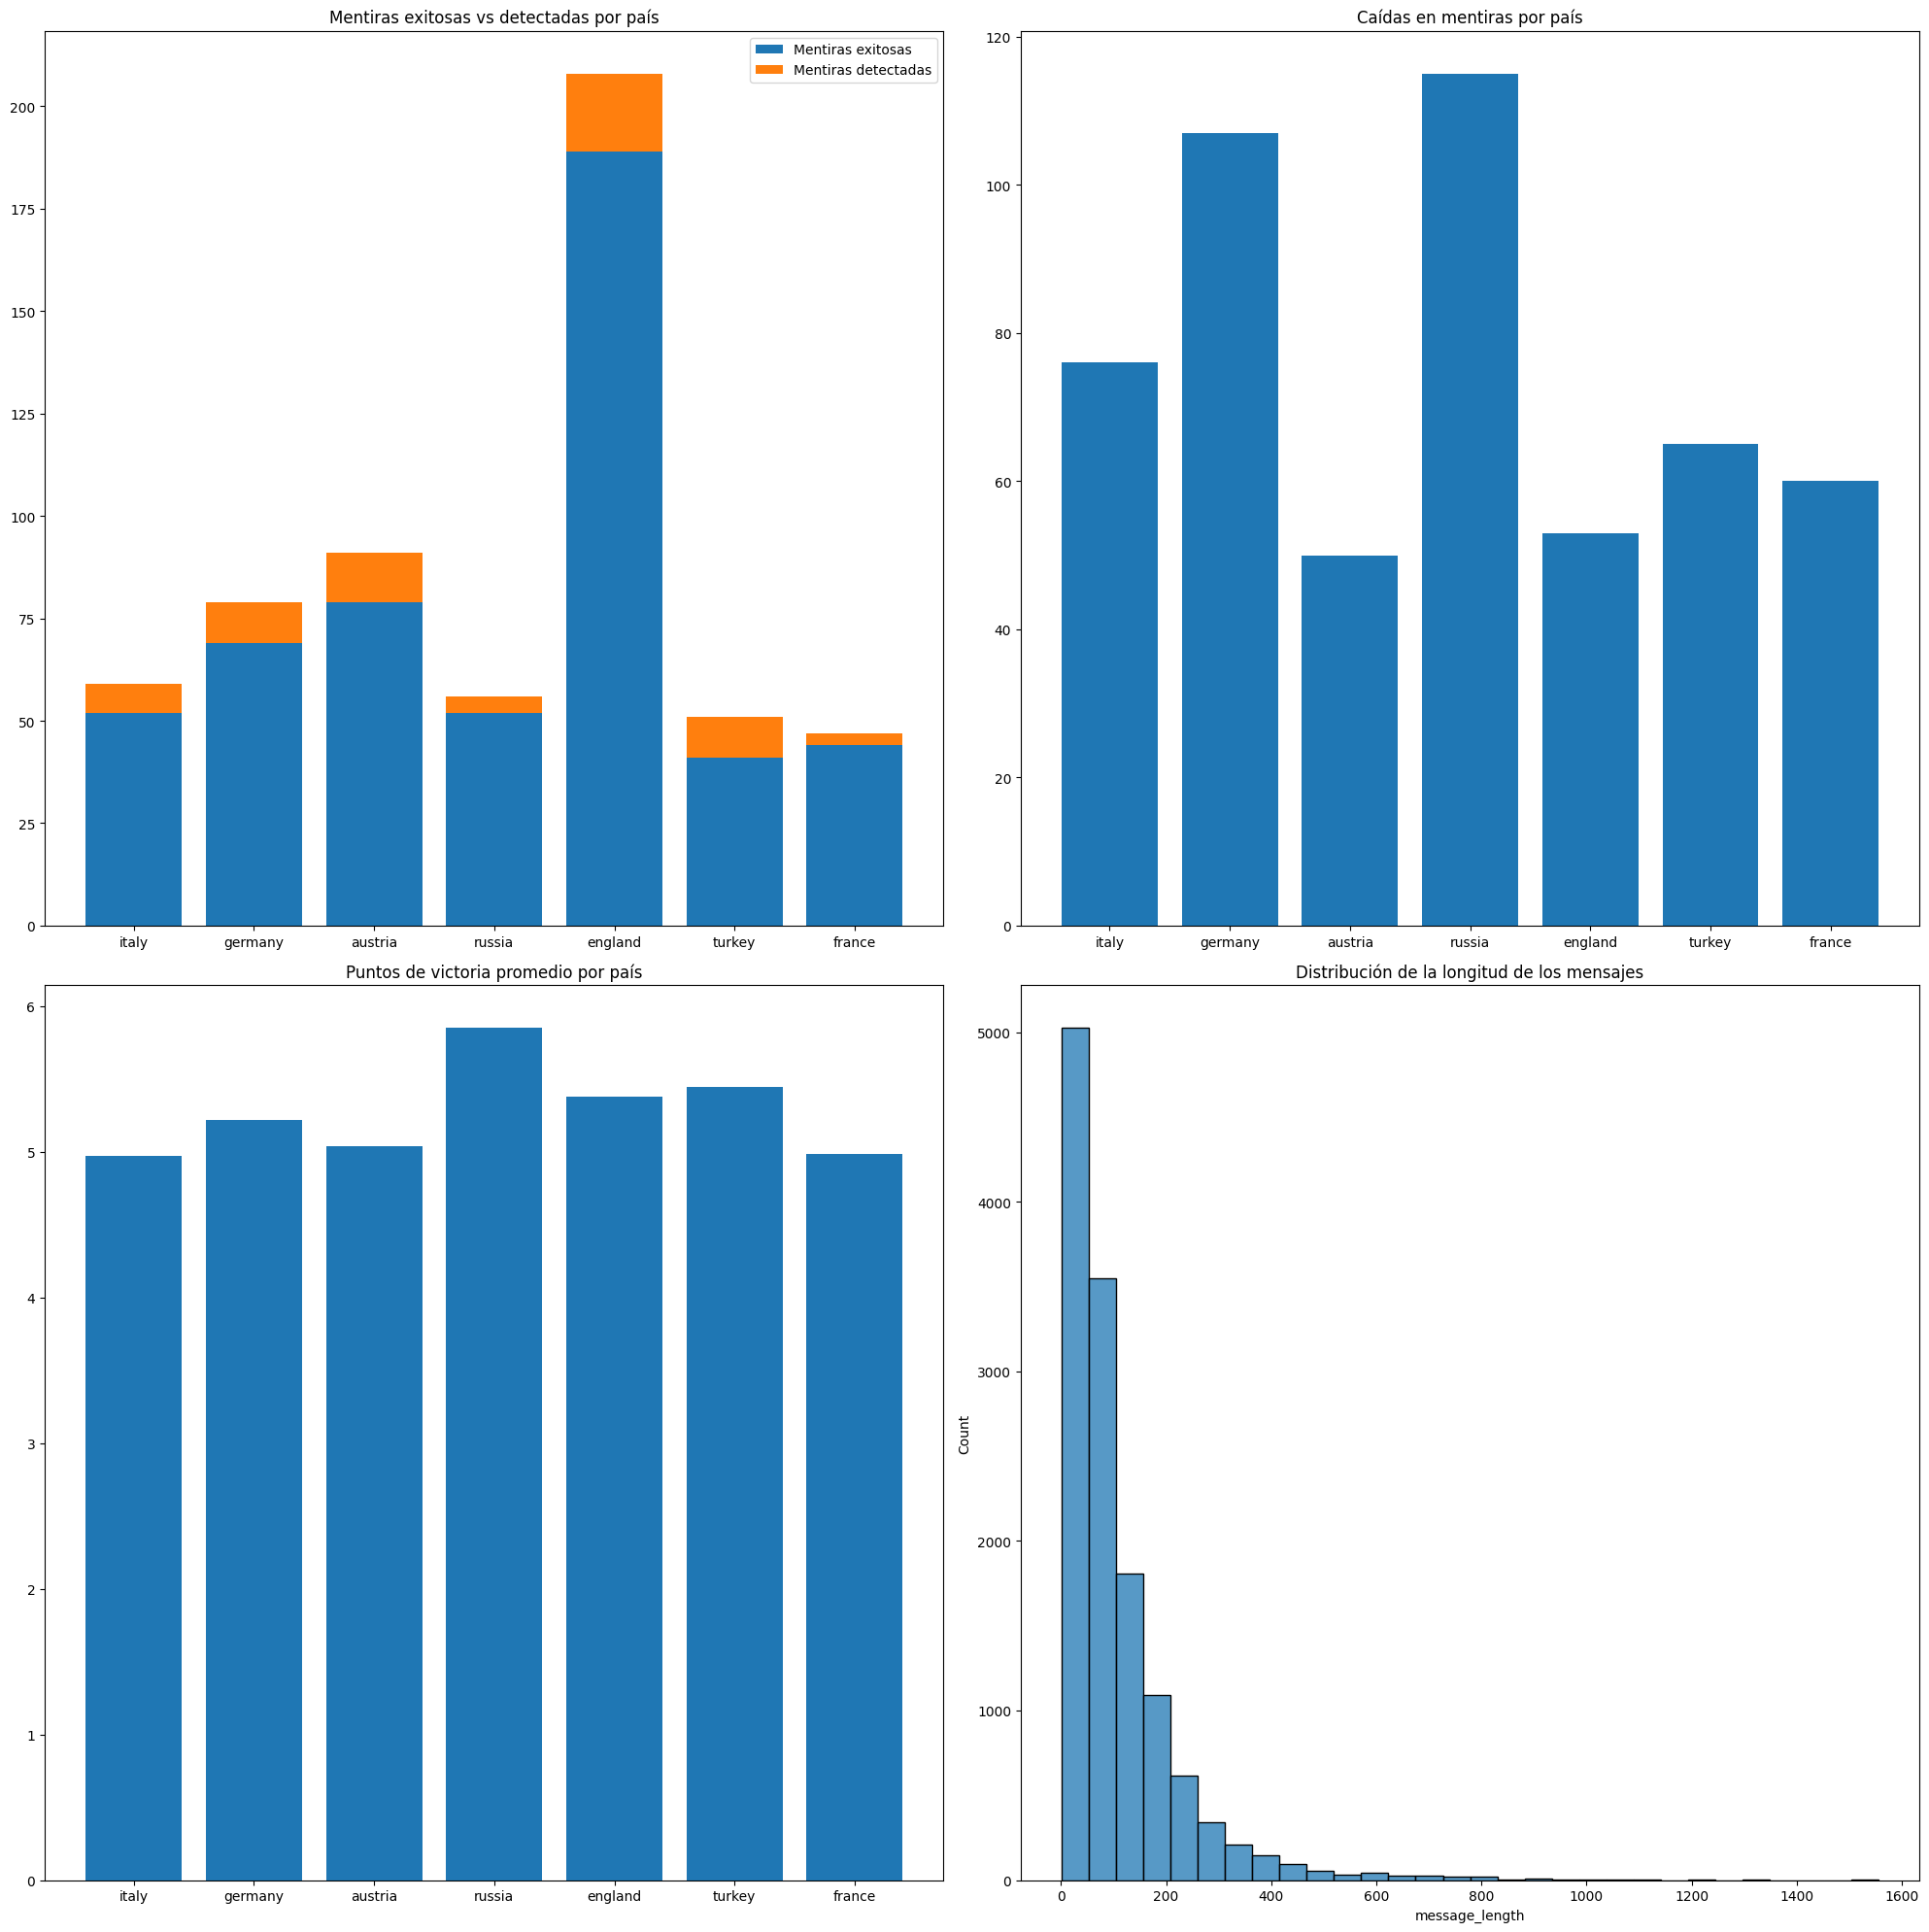

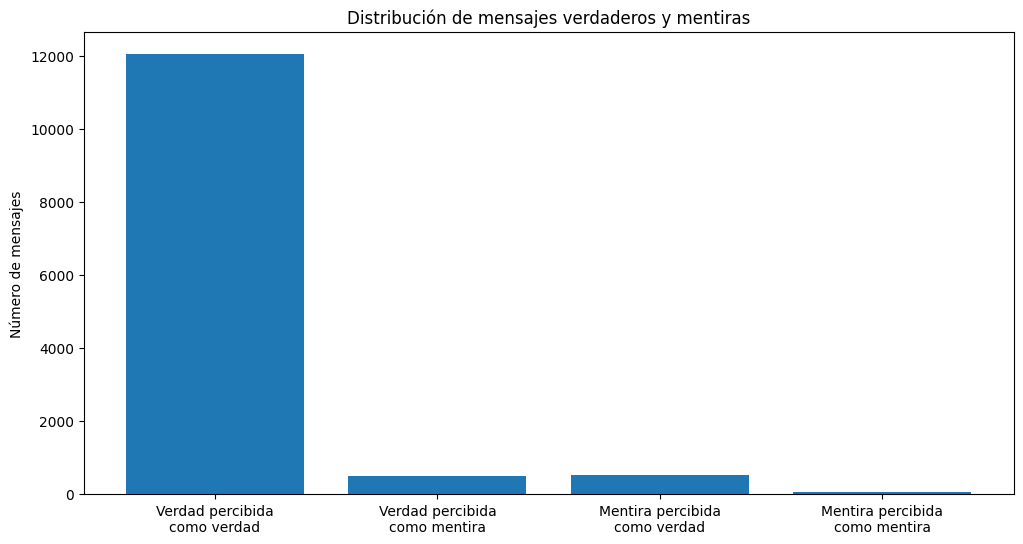

Promedio de palabras por mensaje: 107.51
Porcentaje de mentiras: 4.50%
Porcentaje de mentiras percibidas: 4.31%


In [5]:
def plot_lie_statistics(df):
    """
    Genera gráficos de barras apiladas para estadísticas de mentiras por país.
    """
    countries = df['speaker'].unique()
    # Mentiras exitosas
    successful_lies = df[(df['is_lie'] == True) & (df['perceived_lie'] == False)].groupby('speaker').size()
    # Mentiras detectadas
    detected_lies = df[(df['is_lie'] == True) & (df['perceived_lie'] == True)].groupby('speaker').size()
    # Caídas en mentiras
    fallen_for_lies = df[(df['is_lie'] == True) & (df['perceived_lie'] == False)].groupby('receiver').size()
    # Puntos de victoria
    victory_points = df.groupby('speaker')['game_score'].mean()
    # Crear gráfico de barras apiladas
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    axs[0, 0].bar(countries, successful_lies, label='Mentiras exitosas')
    axs[0, 0].bar(countries, detected_lies, bottom=successful_lies, label='Mentiras detectadas')
    axs[0, 0].set_title('Mentiras exitosas vs detectadas por país')
    axs[0, 0].legend()
    
    axs[0, 1].bar(countries, fallen_for_lies)
    axs[0, 1].set_title('Caídas en mentiras por país')
    
    axs[1, 0].bar(countries, victory_points)
    axs[1, 0].set_title('Puntos de victoria promedio por país')
    
    # Distribución de la longitud de los mensajes
    sns.histplot(df['message_length'], bins=30, ax=axs[1, 1])
    axs[1, 1].set_title('Distribución de la longitud de los mensajes')
    
    plt.tight_layout()
    plt.show()

def plot_truth_lie_distribution(df):
    """
    Genera un gráfico de barras para la distribución de mensajes verdaderos y mentiras.
    """
    truth_perceived_truth = df[(df['is_lie'] == False) & (df['perceived_lie'] == False)].shape[0]
    truth_perceived_lie = df[(df['is_lie'] == False) & (df['perceived_lie'] == True)].shape[0]
    lie_perceived_truth = df[(df['is_lie'] == True) & (df['perceived_lie'] == False)].shape[0]
    lie_perceived_lie = df[(df['is_lie'] == True) & (df['perceived_lie'] == True)].shape[0]
    
    categories = ['Verdad percibida\ncomo verdad', 'Verdad percibida\ncomo mentira', 
                  'Mentira percibida\ncomo verdad', 'Mentira percibida\ncomo mentira']
    values = [truth_perceived_truth, truth_perceived_lie, lie_perceived_truth, lie_perceived_lie]
    
    plt.figure(figsize=(12, 6))
    plt.bar(categories, values)
    plt.title('Distribución de mensajes verdaderos y mentiras')
    plt.ylabel('Número de mensajes')
    plt.show()

def perform_eda(df):
    """
    Realiza el análisis exploratorio de datos y genera gráficos.
    """
    plot_lie_statistics(df)
    plot_truth_lie_distribution(df)
    
    # Estadísticas adicionales
    print(f"Promedio de palabras por mensaje: {df['message_length'].mean():.2f}")
    print(f"Porcentaje de mentiras: {df['is_lie'].mean() * 100:.2f}%")
    print(f"Porcentaje de mentiras percibidas: {df['perceived_lie'].mean() * 100:.2f}%")

# Realizar EDA
perform_eda(train_df)

In [12]:
def prepare_data_for_bert(df, tokenizer, max_length=128):
    """
    Prepara los datos para el modelo BERT.
    """
    encodings = tokenizer(df['message'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    labels = torch.tensor(df['is_lie'].astype(int).tolist())
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    return dataset

def train_bert_model(model, train_dataloader, val_dataloader, epochs=3, learning_rate=2e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        
        print(f"Época {epoch+1}/{epochs}")
        print(f"Pérdida de entrenamiento: {train_loss/len(train_dataloader):.4f}")
        print(f"Pérdida de validación: {val_loss/len(val_dataloader):.4f}")
    
    return model

# Crear modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Preparar datos para BERT
train_dataset = prepare_data_for_bert(train_df, tokenizer)
val_dataset = prepare_data_for_bert(val_df, tokenizer)
test_dataset = prepare_data_for_bert(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Entrenar modelo
trained_model = train_bert_model(model, train_dataloader, val_dataloader)

# Guardar modelo entrenado
torch.save(trained_model.state_dict(), 'trained_bert_model.pth')
print("Modelo entrenado guardado.")

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/tokenizer_config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)')))"), '(Request ID: 05c455a3-a76e-465a-8e2b-a9efa51ed1b3)')

In [ ]:
# Evaluación del modelo
def predict_bert(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

predictions, true_labels = predict_bert(trained_model, test_dataloader)

print("Evaluación del modelo:")
print(classification_report(true_labels, predictions))

# Calcular el macro F1-score
macro_f1 = f1_score(true_labels, predictions, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")

# Comparar con el resultado del paper
paper_macro_f1 = 0.57
print(f"Macro F1-score del mejor modelo en el paper: {paper_macro_f1:.4f}")
print(f"Diferencia: {macro_f1 - paper_macro_f1:.4f}")

# Visualizar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - BERT Classifier')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

# Calcular y mostrar métricas adicionales
accuracy = np.sum(np.array(true_labels) == np.array(predictions)) / len(true_labels)
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")